In [2]:
# Marathi Word Sentiment Labeling via NLTK SentiWordNet
# Step 1: Imports & Downloads
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Ensure required NLTK data is present
needed = ["wordnet", "omw-1.4", "sentiwordnet"]
for pkg in needed:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg)

DATA_FILE = Path("marathi_sentiwordnet_google.csv")
OUTPUT_FILE = Path("marathi_word_sentiments.csv")

print("Input file exists:", DATA_FILE.exists())


Input file exists: True


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ashpa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ashpa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Step 2: Load & Basic Cleaning
# Expecting columns: marathi_word,pos,synset_id,gloss,english_word (per earlier sample)
raw_cols = ["marathi_word","pos","synset_id","gloss","english_word"]
df = pd.read_csv(DATA_FILE)
print("Original shape:", df.shape)
# Keep only needed columns if they exist
available = [c for c in raw_cols if c in df.columns]
df = df[available].copy()

# Rename english_word -> english_translation for clarity
if "english_word" in df.columns:
    df = df.rename(columns={"english_word":"english_translation"})

# Drop rows with missing marathi_word OR translation
df = df.dropna(subset=["marathi_word","english_translation"])\
       .drop_duplicates(subset=["marathi_word","english_translation"])

# Basic normalization: strip whitespace, collapse multiple spaces
space_re = re.compile(r"\s+")
df["marathi_word"] = df["marathi_word"].astype(str).str.strip()
df["english_translation"] = (df["english_translation"].astype(str)
                               .str.strip()
                               .str.replace(space_re, " ", regex=True))

print("Cleaned shape:", df.shape)
df.head()

Original shape: (50886, 5)
Cleaned shape: (38619, 5)


,marathi_word,pos,synset_id,gloss,english_translation
0,अजन्मा,adjective,101,"ज्यास जन्म नाही असा:""ईश्वर अजन्मा आहे""",indiscriminateness
1,अशुभ,adjective,101,"शुभ नाही असा:""या योगामूळे कुंडलीतील इतर अशुभ य...",ominous
2,अमंगळ,adjective,101,"शुभ नाही असा:""या योगामूळे कुंडलीतील इतर अशुभ य...",unpreigning
3,अप्रविष्ट,adjective,111,"ज्याने प्रवेश केला नाही असा:""अप्रविष्ट व्यक्ती...",unprecedented
4,पुण्यभूमी,unknown,37,"पवित्र मानले गेलेले स्थान:""हिंदूंसाठी काशी ही ...",virtue


In [4]:
# Step 3: Helper functions to fetch SentiWordNet scores
from functools import lru_cache

def normalize_english_token(tok: str) -> str:
    # Remove surrounding punctuation/brackets artifacts like [ Map on page 22]
    tok = re.sub(r"\[[^]]+\]", " ", tok)  # drop bracketed segments
    tok = re.sub(r"[^A-Za-z_ ]", " ", tok)
    tok = tok.strip().lower()
    # If multiple words keep first token (approximation)
    if " " in tok:
        tok = tok.split()[0]
    return tok

@lru_cache(maxsize=4096)
def senti_scores_for_lemma(lemma: str):
    if not lemma:
        return 0.0, 0.0, 0.0
    synsets = wn.synsets(lemma)
    pos_scores = []
    neg_scores = []
    obj_scores = []
    for syn in synsets:
        try:
            swn_syn = swn.senti_synset(f"{syn.name()}")
            pos_scores.append(swn_syn.pos_score())
            neg_scores.append(swn_syn.neg_score())
            obj_scores.append(swn_syn.obj_score())
        except Exception:
            continue
    if not pos_scores:
        return 0.0, 0.0, 0.0
    return (float(np.mean(pos_scores)),
            float(np.mean(neg_scores)),
            float(np.mean(obj_scores)))

print(senti_scores_for_lemma("good"))

(0.5694444444444444, 0.004629629629629629, 0.42592592592592593)


In [5]:
# Step 4: Compute scores & assign labels
score_rows = []
for idx, row in df.iterrows():
    eng = normalize_english_token(row.get("english_translation", ""))
    pos, neg, obj = senti_scores_for_lemma(eng)
    # Determine label
    if pos == 0 and neg == 0:
        label = "neutral"
    else:
        if pos - neg > 0.05:  # small margin to avoid near-ties
            label = "+"
        elif neg - pos > 0.05:
            label = "-"
        else:
            label = "neutral"
    score_rows.append((pos, neg, obj, label))

score_df = pd.DataFrame(score_rows, columns=["pos_score","neg_score","obj_score","sentiment_label"], index=df.index)

df_scored = pd.concat([df, score_df], axis=1)
print(df_scored.head(10))
print(df_scored['sentiment_label'].value_counts())

  marathi_word        pos  synset_id  \
0       अजन्मा  adjective        101   
1         अशुभ  adjective        101   
2        अमंगळ  adjective        101   
3    अप्रविष्ट  adjective        111   
4    पुण्यभूमी    unknown         37   
5   पवित्रभूमी    unknown         37   
6   पुण्यस्थान    unknown         37   
7  पवित्रस्थान    unknown         37   
8    पावनस्थान    unknown         37   
9       शिवालय       noun         37   

                                               gloss english_translation  \
0             ज्यास जन्म नाही असा:"ईश्वर अजन्मा आहे"  indiscriminateness   
1  शुभ नाही असा:"या योगामूळे कुंडलीतील इतर अशुभ य...             ominous   
2  शुभ नाही असा:"या योगामूळे कुंडलीतील इतर अशुभ य...         unpreigning   
3  ज्याने प्रवेश केला नाही असा:"अप्रविष्ट व्यक्ती...       unprecedented   
4  पवित्र मानले गेलेले स्थान:"हिंदूंसाठी काशी ही ...              virtue   
5  पवित्र मानले गेलेले स्थान:"हिंदूंसाठी काशी ही ...              ground   
6  पवित्र मानले गेलेले स्था

Using downloaded Noto Sans Devanagari font.
Using font for Devanagari: .cache_fonts\NotoSansDevanagari-Regular.ttf
Frequencies count: 300 (displaying up to 300)
Sample frequencies (first 10): [('गडबड', 2), ('योग्य', 2), ('स्मरण', 2), ('भोक्ता', 2), ('प्रार्थना', 2), ('नल्ल', 2), ('एक', 2), ('शनी', 2), ('प्लूटो', 2), ('प्रदेश', 2)]
Using downloaded Noto Sans Devanagari font.
Using font for Devanagari: .cache_fonts\NotoSansDevanagari-Regular.ttf
Frequencies count: 300 (displaying up to 300)
Sample frequencies (first 10): [('गडबड', 2), ('योग्य', 2), ('स्मरण', 2), ('भोक्ता', 2), ('प्रार्थना', 2), ('नल्ल', 2), ('एक', 2), ('शनी', 2), ('प्लूटो', 2), ('प्रदेश', 2)]


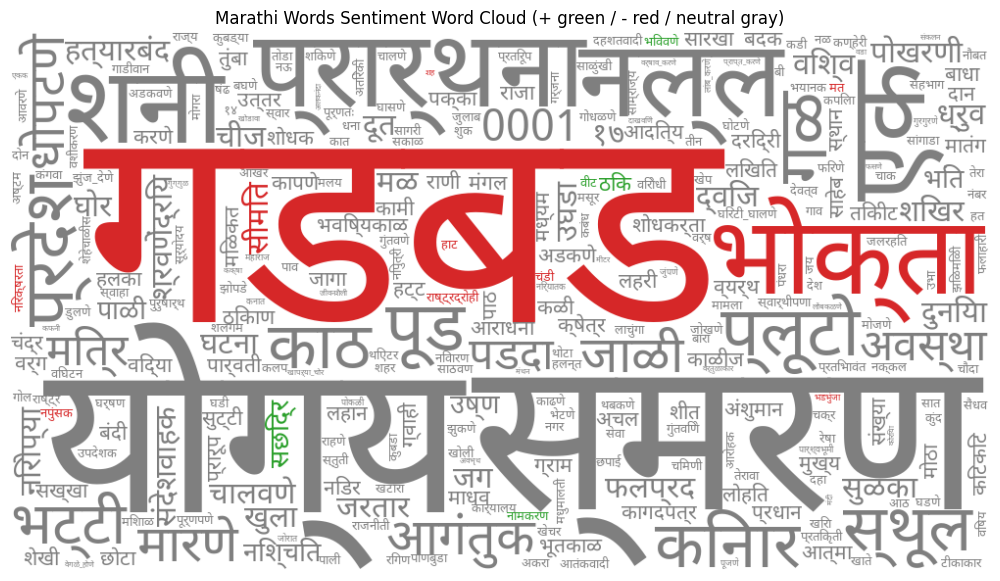

In [8]:
# Step 5: Word Cloud visualization (color by sentiment label)
# Improvements:
# 1. Auto-detect a font that supports Devanagari (Marathi) script (e.g., Nirmala UI, Mangal). 
# 2. Optionally include English translation tokens (set include_english=True).
# 3. Use a regex accepting both Devanagari and Latin characters.
# 4. Provide debug prints if frequencies end up empty.
# 5. Allow weighting by polarity magnitude if desired.
# 6. Fallback: attempt download of Noto Sans Devanagari if no system font found.

import os, sys, urllib.request, zipfile, io
from collections import Counter
from pathlib import Path

include_english = False          # Set True to mix English translations
weight_by_polarity = False        # Set True to weight words by |pos-neg|
max_words = 300                   # Limit for clarity

# Build frequency map
if weight_by_polarity:
    def word_weight(row):
        return max(1e-3, abs(row.get("pos_score",0) - row.get("neg_score",0)))
    freq_items = []
    for _, r in df_scored.iterrows():
        mw = str(r["marathi_word"]).strip()
        if mw:
            freq_items.append((mw, word_weight(r)))
        if include_english:
            eng_tok = normalize_english_token(r.get("english_translation",""))
            if eng_tok:
                freq_items.append((eng_tok, word_weight(r)))
    frequencies = {}
    for w, val in freq_items:
        frequencies[w] = frequencies.get(w, 0) + val
else:
    tokens = []
    for _, r in df_scored.iterrows():
        mw = str(r["marathi_word"]).strip()
        if mw:
            tokens.append(mw)
        if include_english:
            eng_tok = normalize_english_token(r.get("english_translation",""))
            if eng_tok:
                tokens.append(eng_tok)
    tokens = [t for t in tokens if t]
    frequencies = Counter(tokens)

# Reduce to top-N if very large
if len(frequencies) > max_words:
    frequencies = dict(sorted(frequencies.items(), key=lambda kv: kv[1], reverse=True)[:max_words])

# Map word -> sentiment label (Marathi words only for coloring; English fallback neutral)
label_map = dict(zip(df_scored["marathi_word"], df_scored["sentiment_label"]))

colors = {"+":"#2ca02c", "-":"#d62728", "neutral":"#7f7f7f"}

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    label = label_map.get(word, "neutral")
    return colors.get(label, "#7f7f7f")

# Font detection for Devanagari
possible_fonts = [
    "Nirmala.ttf", "NirmalaUI.ttf", "NirmalaUI-Regular.ttf",  # Nirmala UI variants
    "Mangal.ttf", "MANGAL.TTF",
    "Kokila.ttf", "kokila.ttf",
    "Arial Unicode MS.ttf", "ARIALUNI.TTF"
]
font_path = None
windows_font_dir = Path("C:/Windows/Fonts")
if windows_font_dir.exists():
    for fname in possible_fonts:
        fp = windows_font_dir / fname
        if fp.exists():
            font_path = str(fp)
            break

# Fallback: download Noto Sans Devanagari Regular
if font_path is None:
    noto_url = "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf"
    try:
        cache_dir = Path(".cache_fonts")
        cache_dir.mkdir(exist_ok=True)
        local_font = cache_dir / "NotoSansDevanagari-Regular.ttf"
        if not local_font.exists():
            print("Downloading Noto Sans Devanagari...")
            urllib.request.urlretrieve(noto_url, local_font)
        font_path = str(local_font)
        print("Using downloaded Noto Sans Devanagari font.")
    except Exception as e:
        print("[Warning] Could not download fallback font:", e)

if font_path is None:
    print("[Warning] No Devanagari-capable font found. Marathi glyphs may not render. Set font_path manually.")
else:
    print("Using font for Devanagari:", font_path)

# Regex: include Devanagari (0900-097F) and Latin letters & underscore
from wordcloud import WordCloud
wc = WordCloud(
    width=1000,
    height=550,
    background_color="white",
    prefer_horizontal=0.9,
    collocations=False,
    font_path=font_path,
    regexp=r"[\u0900-\u097F_a-zA-Z]+",
    max_words=max_words
)

print(f"Frequencies count: {len(frequencies)} (displaying up to {max_words})")
if not frequencies:
    print("[Debug] Frequencies dict is empty. Check earlier preprocessing.")
else:
    sample_items = list(frequencies.items())[:10]
    print("Sample frequencies (first 10):", sample_items)

wc.generate_from_frequencies(frequencies)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.imshow(wc.recolor(color_func=color_func, random_state=3), interpolation="bilinear")
plt.axis("off")
plt.title("Marathi Words Sentiment Word Cloud (+ green / - red / neutral gray)" + (" + English" if include_english else ""))
plt.show()

In [9]:
# Diagnostics: Inspect token coverage and Unicode ranges before word cloud
import unicodedata

print("Total rows:", len(df_scored))
print("Unique Marathi words:", df_scored['marathi_word'].nunique())

# Show a sample of first 15 Marathi words
sample_words = df_scored['marathi_word'].astype(str).head(15).tolist()
print("Sample Marathi words:", sample_words)

# Check if words actually contain Devanagari codepoints
def has_devanagari(w):
    return any(0x0900 <= ord(ch) <= 0x097F for ch in w)

num_deva = sum(has_devanagari(w) for w in df_scored['marathi_word'])
print(f"Words containing Devanagari characters: {num_deva} / {len(df_scored)}")

# List first few words without Devanagari (could be transliterated / noise)
non_deva = [w for w in df_scored['marathi_word'] if not has_devanagari(w)]
print("First 10 non-Devanagari entries:", non_deva[:10])

# Frequency distribution (top 10)
from collections import Counter
freq_counter = Counter(df_scored['marathi_word'])
print("Top 10 frequency items:", freq_counter.most_common(10))

# If zero Devanagari words, likely input file uses transliteration or encoding issue.
if num_deva == 0:
    print("[ALERT] No Devanagari characters detected. Word cloud will look empty or show placeholders. Check encoding or source file.")

Total rows: 38619
Unique Marathi words: 38212
Sample Marathi words: ['अजन्मा', 'अशुभ', 'अमंगळ', 'अप्रविष्ट', 'पुण्यभूमी', 'पवित्रभूमी', 'पुण्यस्थान', 'पवित्रस्थान', 'पावनस्थान', 'शिवालय', 'शिवमंदिर', 'अपवित्र_स्थान', 'आलेला', 'आगत', 'जन्मलेला']
Words containing Devanagari characters: 38585 / 38619
First 10 non-Devanagari entries: ['0001', '60', '18', '14', '29', '47', '100000000000', '17', '36', '58']
Top 10 frequency items: [('गडबड', 2), ('योग्य', 2), ('स्मरण', 2), ('भोक्ता', 2), ('प्रार्थना', 2), ('नल्ल', 2), ('एक', 2), ('शनी', 2), ('प्लूटो', 2), ('प्रदेश', 2)]


In [10]:
# Step 6: Save final dataset
save_cols = [c for c in ["marathi_word","sentiment_label","pos_score","neg_score","obj_score","english_translation","synset_id","pos"] if c in df_scored.columns]
final_df = df_scored[save_cols].copy()
final_df.to_csv(OUTPUT_FILE, index=False, encoding="utf-8")
print("Saved labeled dataset to:", OUTPUT_FILE.resolve())
final_df.head(10)

Saved labeled dataset to: C:\LLM's_for_SA\marathi_word_sentiments.csv


,marathi_word,sentiment_label,pos_score,neg_score,obj_score,english_translation,synset_id,pos
0,अजन्मा,neutral,0.000,0.00000,0.00000,indiscriminateness,101,adjective
1,अशुभ,-,0.125,0.75000,0.12500,ominous,101,adjective
2,अमंगळ,neutral,0.000,0.00000,0.00000,unpreigning,101,adjective
3,अप्रविष्ट,neutral,0.000,0.00000,1.00000,unprecedented,111,adjective
4,पुण्यभूमी,+,0.625,0.15625,0.21875,virtue,37,unknown
5,पवित्रभूमी,neutral,0.000,0.00000,1.00000,ground,37,unknown
6,पुण्यस्थान,+,0.625,0.15625,0.21875,virtue,37,unknown
7,पवित्रस्थान,+,0.375,0.12500,0.50000,sanctity,37,unknown
8,पावनस्थान,neutral,0.000,0.00000,1.00000,postage,37,unknown
9,शिवालय,neutral,0.000,0.00000,0.00000,shivala,37,noun
